In [1]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import tqdm
import scipy.signal
import statsmodels.tsa.stattools
import statsmodels.tsa.seasonal

In [72]:
#define time interval, T should be integer
T = 21000
window_length = 700 


#build hysteresis with small epsilon to slow down process

epsilon = 0.005

def mu(t):
    return 2/(2/3*T) * t - 1                                      

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))

In [73]:

def get_equilibria_paths():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[2.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[-2.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,ts[i]),(0.0,50),[0.0], method="BDF")
        unstable[i] = sol.y[0,-1]
     
    unstable[np.abs(unstable)>1] = np.nan

    return ts,upper,lower,unstable

In [74]:
ts,upper,lower,unstable = get_equilibria_paths()

true_ls = 1 - upper**2

100%|██████████| 21001/21001 [30:31<00:00, 11.46it/s]


In [6]:
def get_var(x):
    n_windows = int(T/window_length) 
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
    n_windows = int(T/window_length) 
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar


In [7]:

def get_ls(x,noise,a):

    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)

    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[i]*np.arange(0,window_length)) @ (noise_window*a)))**2 for i in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                  frequencies, 
                                                  np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls

In [84]:
#numerical simulation of SDEs:

n_steps_per_unit_time = 10               
n_steps = T*n_steps_per_unit_time + 1                                        
solve_ts = np.linspace(0,T,n_steps)
dt = 1/n_steps_per_unit_time


#red noise case

xs_red = np.zeros(n_steps)
red_noise = np.zeros(n_steps)
xs_red[0] = upper[0]                                                           
kappa = 0.01            


for i in tqdm.trange(n_steps - 1):
    red_noise[i+1] = np.exp(-dt)*red_noise[i] + np.sqrt(1/2*(1-np.exp(-2*dt)))*np.random.normal(0,1)


for i in tqdm.trange(n_steps - 1):
    xs_red[i+1] = xs_red[i] + epsilon*f(xs_red[i],solve_ts[i])*dt + kappa*red_noise[i]*dt


xs_red_filtered = xs_red[::n_steps_per_unit_time]



100%|██████████| 210000/210000 [00:00<00:00, 420949.22it/s]


In [85]:
variance_series_red = get_var(xs_red_filtered)
ac_series_red = get_ar(xs_red_filtered)


red_noise_filtered = np.array([np.sum([red_noise[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])

ls_red = get_ls(xs_red_filtered,red_noise_filtered,kappa)      

100%|██████████| 30/30 [00:01<00:00, 19.47it/s]


Text(0.5, 0, '$\\mu(t)$')

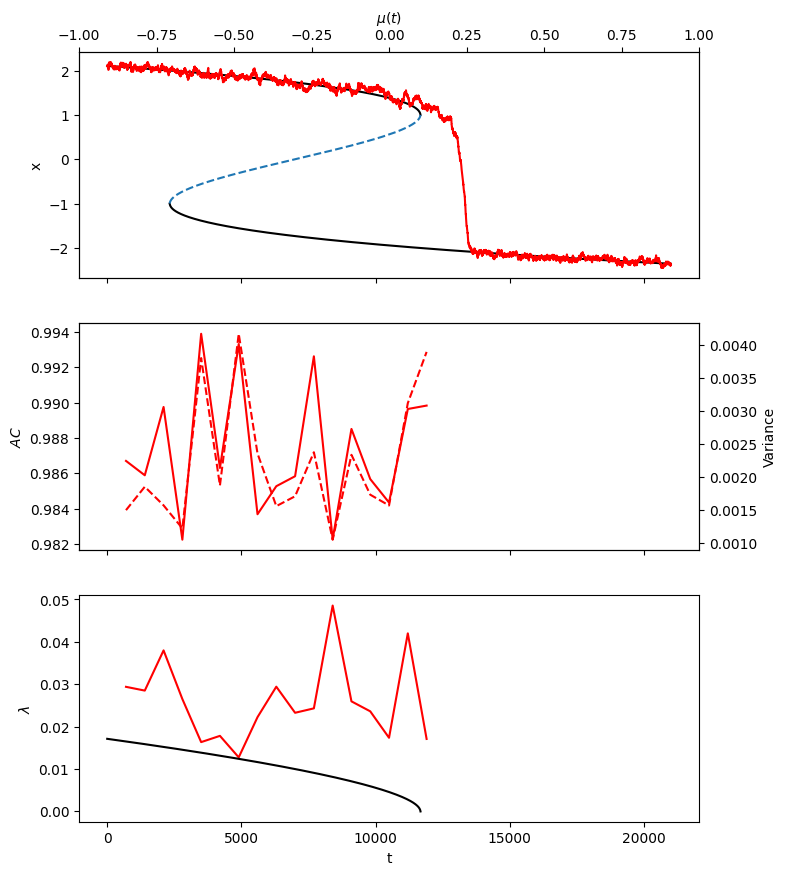

In [86]:
tipp_upper = np.argmin(upper>1)
tipp_lower = np.argmin(lower>-1)


tip_red = np.argmin(xs_red_filtered>1.0)  


fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts[:tipp_upper],upper[:tipp_upper],color = "black")
axs[0].plot(ts[tipp_lower:],lower[tipp_lower:],color = "black")
axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
axs[0].plot(ts,xs_red_filtered,color="red")




axs[1].plot(ts[window_length:tip_red:window_length],ac_series_red[:int(tip_red/window_length)],color="red")
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length:tip_red:window_length],variance_series_red[:int(tip_red/window_length)],color="red",linestyle="--")


axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")



axs[2].set_xlabel("t")    
axs[2].plot(ts[window_length:tip_red:window_length],ls_red[:int(tip_red/window_length)],color="red")
axs[2].plot(ts[:tipp_upper],-epsilon*true_ls[:tipp_upper],color="black")
axs[2].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel(r"$\mu(t)$")
